In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks



In [2]:
video_path = '../video_samples/news.mpg'


In [3]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(video_path)
# Read until video is completed
count = 0
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    count+=1
    # Display the resulting frame
    cv2.imshow('Frame',frame)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

In [14]:
cap = cv2.VideoCapture(video_path)
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames = [np.zeros(shape = (frameHeight, frameWidth))]
original_frames = []
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read() # first frame
  if ret == True:
    original_frames.append(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)
  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()


np_original_video = np.array(original_frames, dtype = np.dtype('uint8'))


[mpeg1video @ 0x55bb3e53dd00] ac-tex damaged at 0 10
[mpeg1video @ 0x55bb3e53dd00] Warning MVs not available


## Pixel Difference

In [143]:
220/255

0.8627450980392157

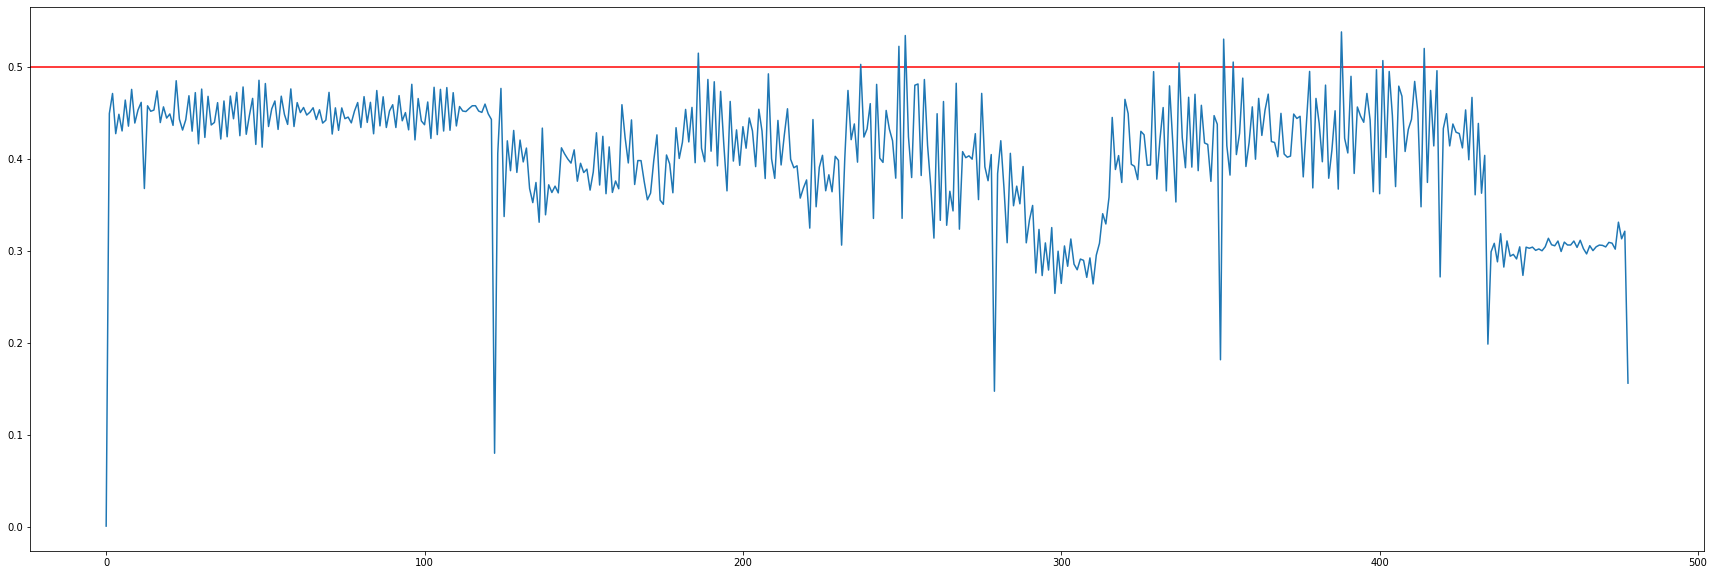

In [147]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
diffs = np.abs(np.diff(np_video, 1, axis = 0))
img_dim = np_video.shape[1] * np_video.shape[2]
count = np.count_nonzero(diffs > 220, axis = (1,2))/img_dim
np_video = np.delete(np_video, 0, axis = 0)
fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 0.5, color = 'r', linestyle = '-')
ax.plot(count[0:])

In [141]:
selected_frames = ((np.argwhere(count > 50)).ravel())
new_frames = np_video[selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(new_frames))
print('Selected frames: ', selected_frames)


Quantidade de frames original:  479
Quantidade de frames após SBD:  10
Selected frames:  [186 237 249 251 337 351 354 388 401 414]


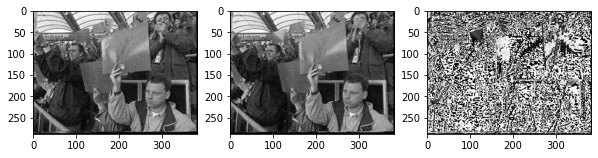

In [7]:
fig, ax = plt.subplots(figsize = (10,10),nrows = 1, ncols = 3)
ax[0].imshow(np_video[400], cmap = 'gray')
ax[1].imshow(np_video[401], cmap = 'gray')
ax[2].imshow(diffs[401], cmap = 'gray')


In [97]:
for frame in new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(200) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


## Block Difference

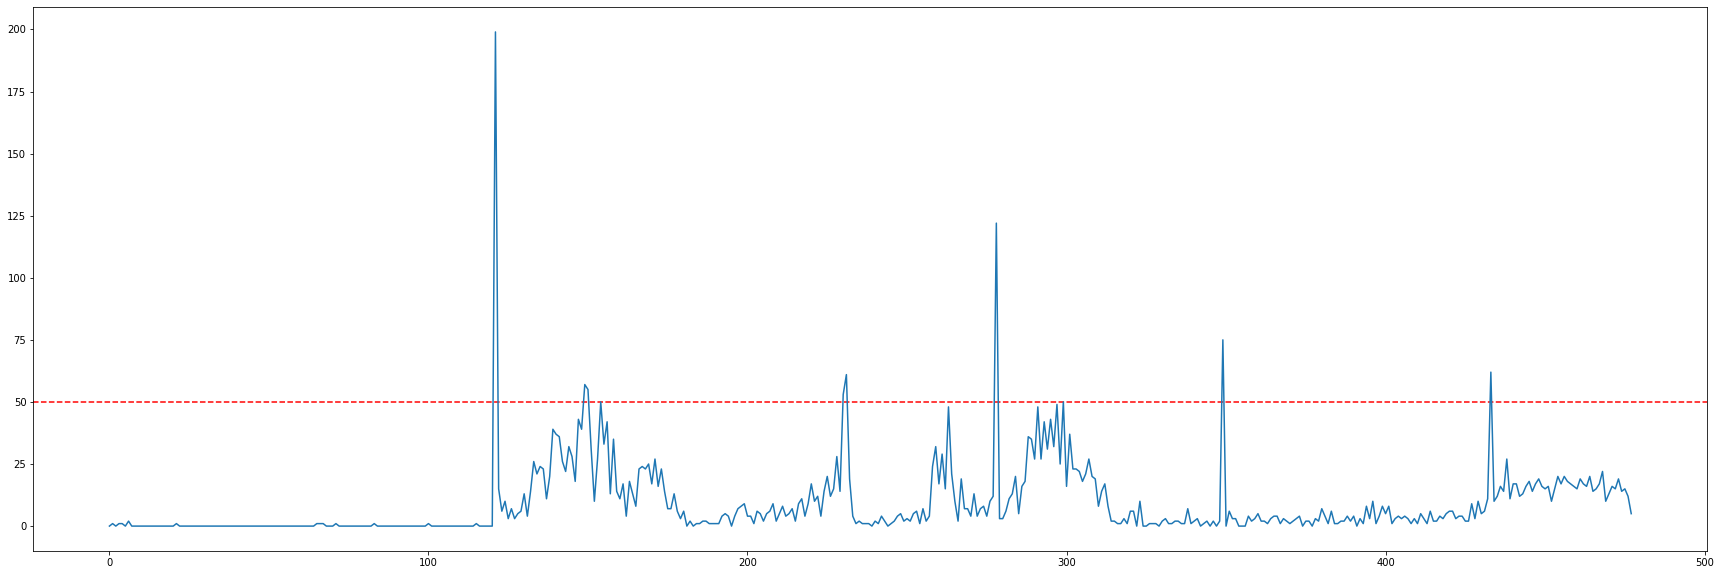

In [131]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
frame_blocks = view_as_blocks(np_video,(1, 8, 8)).squeeze()
block_rmse = np.sqrt((np.diff(np.abs(frame_blocks), axis = 0)**2).mean(axis = (3,4)))
block_percentage_greater_than_T1 = np.count_nonzero(block_rmse > 11.2, axis = (1,2))
np_video = np.delete(np_video, 0, axis = 0)

fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 50, color = 'r', linestyle = '--')
ax.plot(block_percentage_greater_than_T1[1:])

In [133]:
block_selected_frames = ((np.argwhere(block_percentage_greater_than_T1 >= 50)).ravel())
block_new_frames = np_video[block_selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(block_new_frames))
print('Selected frames: ', block_selected_frames)

Quantidade de frames original:  479
Quantidade de frames após SBD:  11
Selected frames:  [  0 122 150 151 155 231 232 279 300 350 434]


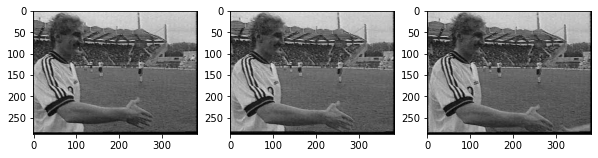

In [209]:
fig, ax = plt.subplots(figsize = (10,10),nrows = 1, ncols = 3)
ax[0].imshow(np_video[135], cmap = 'gray')
ax[1].imshow(np_video[136], cmap = 'gray')
ax[2].imshow(np_video[137], cmap = 'gray')


In [198]:
for frame in block_new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(200) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


## Histogram difference

In [148]:
np_video = np.array(frames, dtype = np.dtype('uint8'))
hist_video = np_video.reshape(np_video.shape[0], -1)
histograms = np.apply_along_axis(lambda x: np.histogram(x, np.arange(256))[0], 1, hist_video)
np_video = np.delete(np_video, 0, axis = 0)


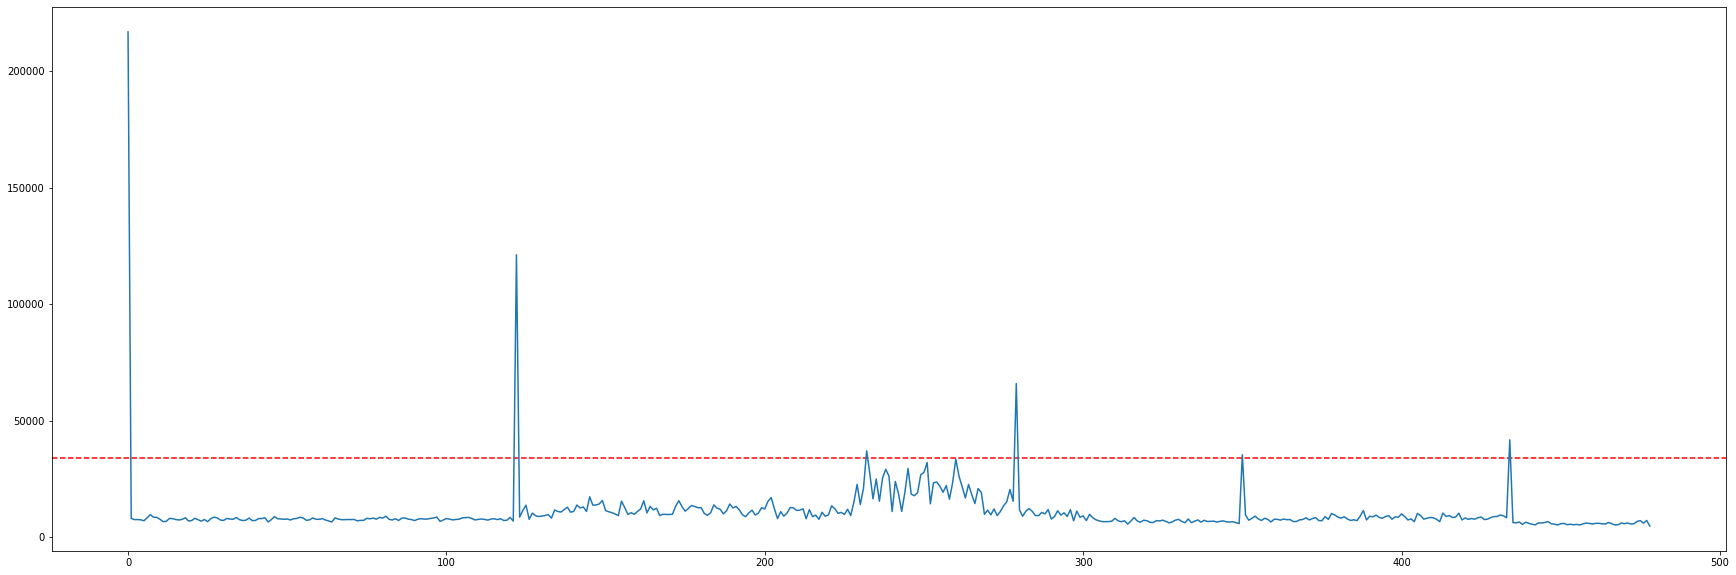

In [149]:
hist_diffs = np.abs(np.diff(histograms, axis = 0))
hist_agg = np.sum(hist_diffs, axis = 1)

fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 34000, color = 'r', linestyle = '--')
ax.plot(hist_agg)

In [150]:
mean = np.mean(hist_agg[1:])
sigma = np.std(hist_agg[1:])
mean + 3.5 * sigma

36713.93380930617

In [152]:
hist_selected_frames = ((np.argwhere(hist_agg >= mean + 3* sigma)).ravel())
hist_new_frames = np_original_video[hist_selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(hist_new_frames))
print('Selected frames: ', hist_selected_frames)


Quantidade de frames original:  479
Quantidade de frames após SBD:  7
Selected frames:  [  0 122 232 260 279 350 434]


In [16]:
for frame in hist_new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(1000) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()


## Mapa de Bordas

In [18]:
from scipy import signal

In [58]:
gx = np.asarray([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])
gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
img = np_video[2]
imgx_convolved = signal.convolve2d(img, gx)
imgy_convolved = signal.convolve2d(img, gy)
sobel_combined = imgy_convolved + imgx_convolved


In [61]:
imgx_convolved = 255.0 * (imgx_convolved - np.min(imgx_convolved))/(np.max(imgx_convolved) - np.min(imgx_convolved))
imgy_convolved = 255.0 * (imgy_convolved - np.min(imgy_convolved))/(np.max(imgy_convolved) - np.min(imgy_convolved))

grad_mag       = np.sqrt(np.square(imgx_convolved) + np.square(imgy_convolved))
grad_mag       = 255.0 * (grad_mag - np.min(grad_mag))/(np.max(grad_mag) - np.min(grad_mag))

sobel_combined = 255.0 * (sobel_combined - np.min(sobel_combined))/(np.max(sobel_combined) - np.min(sobel_combined)) 




grad_mag       = np.where(grad_mag > 127, 255.0, 0)
sobel_combined = np.where(sobel_combined > 127, 255.0, 0)



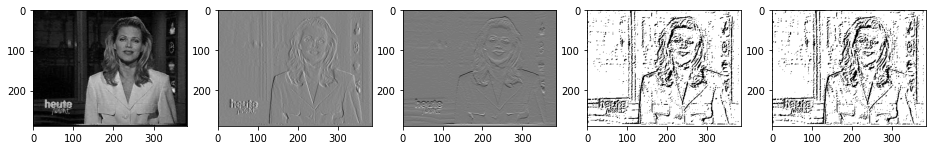

In [62]:
fig, ax = plt.subplots(figsize = (16,8), nrows = 1, ncols = 5)
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(imgx_convolved, cmap = 'gray')
ax[2].imshow(imgy_convolved, cmap = 'gray')
ax[3].imshow(sobel_combined, cmap = 'gray')
ax[4].imshow((grad_mag), cmap = 'gray')





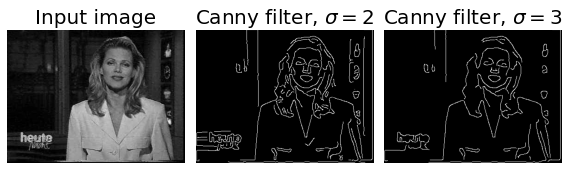

In [67]:
from skimage import feature



# Compute the Canny filter for two values of sigma
edges1 = feature.canny(img, sigma = 2)
edges2 = feature.canny(img, sigma=2.5)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Input image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=2$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

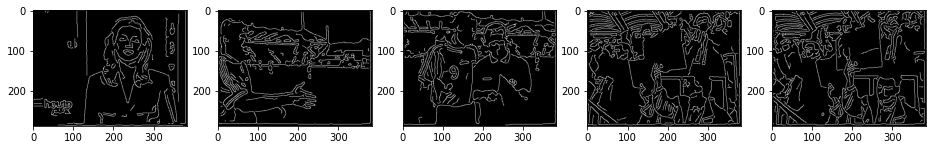

In [93]:
fig, ax = plt.subplots(figsize = (16,8), nrows = 1, ncols = 5)
ax[0].imshow(a[2], cmap = 'gray')
ax[1].imshow(a[130], cmap = 'gray')
ax[2].imshow(a[215], cmap = 'gray')
ax[3].imshow(a[360], cmap = 'gray')
ax[4].imshow(a[400], cmap = 'gray')






In [155]:
# Vou usar canny mesmo
np_video = np.array(frames, dtype = np.dtype('uint8'))
edges = np.array(list(map(lambda x: feature.canny(x, sigma = 2), np_video)))
np_video = np.delete(np_video, 0, axis = 0)


In [102]:
n_edge_pixels = np.sum(edges, axis = (1,2))
n_edge_pixels[0] = 1

/tmp/ipykernel_512683/3404808591.py:4: RuntimeWarning: divide by zero encountered in true_divide
  edge_ratio    = np.where(n_edge_pixels[1:] > n_edge_pixels[:-1], np.divide(n_edge_pixels[1:], n_edge_pixels[:-1]), np.divide(n_edge_pixels[:-1], n_edge_pixels[1:]))


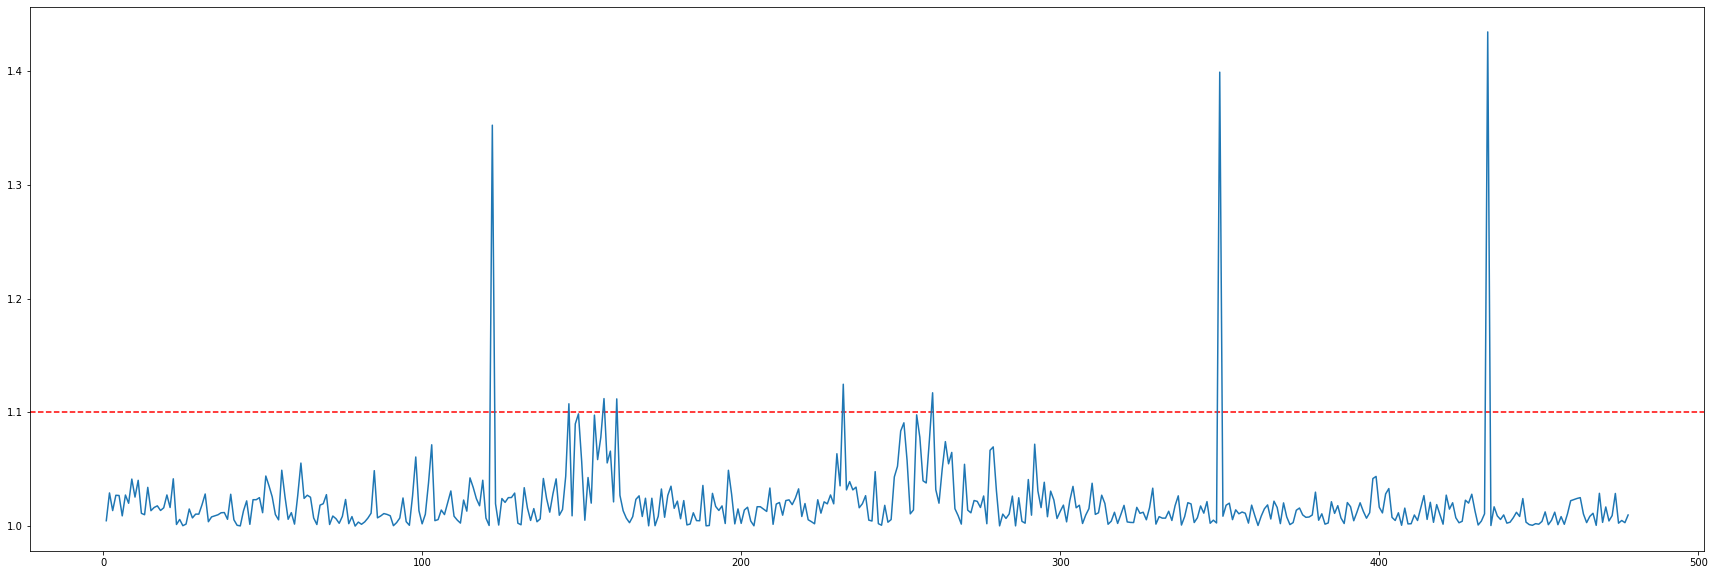

In [113]:
# hist_diffs = np.abs(np.diff(histograms, axis = 0))
# hist_agg = np.sum(hist_diffs, axis = 1)
n_edge_pixels = np.sum(edges, axis = (1,2))
edge_ratio    = np.where(n_edge_pixels[1:] > n_edge_pixels[:-1], np.divide(n_edge_pixels[1:], n_edge_pixels[:-1]), np.divide(n_edge_pixels[:-1], n_edge_pixels[1:]))

fig, ax = plt.subplots(figsize = (30,10))
ax.axhline(y = 1.1, color = 'r', linestyle = '--')
ax.plot(edge_ratio)

In [156]:
edge_selected_frames = ((np.argwhere(edge_ratio >= 1.1)).ravel())
edge_new_frames = np_original_video[edge_selected_frames]
print('Quantidade de frames original: ', len(diffs))
print('Quantidade de frames após SBD: ', len(edge_new_frames))
print('Selected frames: ', edge_selected_frames)


Quantidade de frames original:  479
Quantidade de frames após SBD:  9
Selected frames:  [  0 122 146 157 161 232 260 350 434]


In [116]:
for frame in edge_new_frames:
    cv2.imshow('Frame', frame)

    
    # Press Q on keyboard to  exit
    if cv2.waitKey(1000) & 0xFF == ord('q'):
      break

cv2.destroyAllWindows()
